<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#3498DB'> Chapter9</font></h3>

このノートブックではPymcでMCMCを実行する方法について紹介しています。  
元のノートブックは以下です。  
https://github.com/pymc-devs/pymc-resources/blob/main/Rethinking_2/Chp_09.ipynb

In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy import stats

warnings.simplefilter(action="ignore", category=FutureWarning)
pd.set_option("mode.chained_assignment", None)

In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89 
# sets default credible interval used by arviz

In [3]:
num_weeks = int(1e5)
positions = np.zeros(num_weeks)
current =10
for i in range(num_weeks):
    positions[i] = current
    proposal = current + np.random.choice([-1,1])
    if proposal < 1:
        proposal =10
    if proposal > 10:
        proposal =1
    prob_move = proposal / current
    if np.random.uniform() < prob_move:
        current = proposal

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: メトロポリスアルゴリズムの例</font></h3>

このコードの背景は教科書を参照してください。
ざっくり言うと、環状に並んだ海上の10個の島の巡り方をコイントスで決めています。
* 一週間が過ぎるごとにforループを回す。
* positions[i] = currentでは現在の位置をpositionに格納している。  
  (iはnum_weeksの数だけある)  
* コイントスによって提案される島の番号はproposalになる。
* ただし、島は環状に順番に並んでいるので、島の番号がマイナスになれば10であり、
  10以上であれば番号1の島に行くことにする。
* 移動確率prob_moveをproposal / currentとして定める。
* prob_moveがランダムな0~1の数値より大きい場合、移動する。

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes:簡潔なコード</font></h3>

* if文をより簡潔に以下のように書ける。
  ```
   # Wrap around if proposal is out of [1, 10]  
     if proposal < 1: proposal = 10  
     if proposal > 10: proposal = 1
   ```

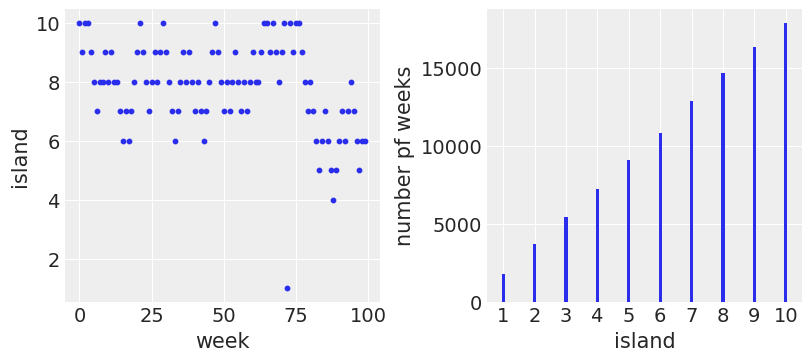

In [4]:
_, axs = plt.subplots(1, 2, figsize=[8, 3.5], constrained_layout=True)

ax0, ax1 = axs

nplot = 100
ax0.scatter(range(nplot), positions[:nplot], s=10)
ax0.set_ylabel("island")
ax0.set_xlabel("week")

counts, _ = np.histogram(positions, bins=10)
ax1.bar(range(10), counts, width=0.1)
ax1.set_ylabel("number pf weeks")
ax1.set_xlabel("island")
ax1.set_xticks(range(10))
ax1.set_xticklabels(range(1, 11));

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: 図による表現</font></h3>

* constrained_layout=Trueは自動的な配置を行い、サブプロットが重ならないようにする。
* ax0, ax1 = axs は、axsから取得したサブプロットオブジェクトを ax0 と ax1 にそれぞれ代入する。
* positionsリストの最初の100個をプロットする。
* scatter()の引数のsはデータポイントの点のサイズ。
* _, axs = plt.subplots()とax0, ax1 = axsでアンパック代入を実行している。

Text(0, 0.5, 'Density')

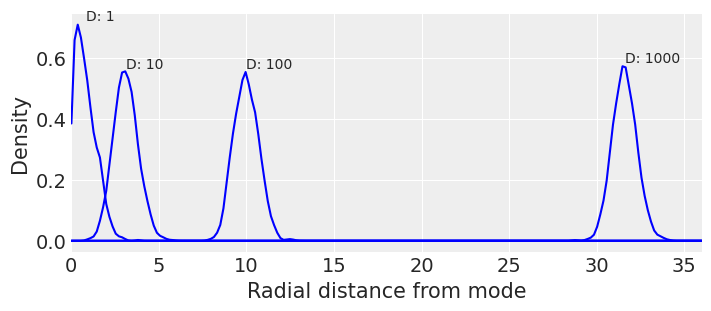

In [5]:
def rad_dist(Y):
    return np.sqrt(np.sum(Y**2))

fig, ax = plt.subplots(1, 1, figsize=[7,3])
xvar = np.linspace(0, 36, 200)

for D in [1, 10, 100, 1000]:
    T = int(1e3)
    Y = stats.multivariate_normal(np.zeros(D), np.identity(D)).rvs(T)
    
    Rd = list(map(rad_dist, Y))

    kde = stats.gaussian_kde(Rd)
    yvar = kde(xvar)
    ax.plot(xvar, yvar, color="b")

    ax.text(np.mean(Rd), np.max(yvar)*1.02, f"D: {D}")

ax.set_xlim(0, 36)
ax.set_xlabel("Radial distance from mode")
ax.set_ylabel("Density")

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 95%; text-align: left">
<h3 align="left"><font color='#3498DB'>🦄 Notes: パラメータ数と次元の呪い</font></h3>

*

In [7]:
def calc_U(x, y, q, a=0, b=1, k=0, d=1):
    muy, mux =q

    U = (
         np.sum(stats.norm.logpdf(y, loc=muy, scale=1))
         + np.sum(stats.norm.logpdf(x, loc=mux, scale=1))
         + stats.norm.logpdf(muy, loc=a, scale=b)
         + stats.norm.logpdf(mux, loc=k, scale=d)
    )

    return -U

In [8]:
# 勾配関数
# Uをqについて偏微分したベクトルが必要

def calc_U_gradient(x, y, q, a=0, b=1, k=0, d=1):
    muy, mux =q

    G1 = np.sum(y - muy) + (a - muy) / b**2  #dU/dmuy
    G2 = np.sum(x - mux) + (k - mux) / b**2  #dU/dmux

    return np.array([-G1, -G2])
    